#### 模型预测
1. 加载之前训练好的模型
2. 任意选取测试集中的图片进行预测

#### 1.加载之前训练好的模型

In [1]:
from keras.layers import *
from keras.regularizers import *
import os
from keras.models import Model
from BilinearUpSampling import *

def FCN_Vgg16_32s(input_shape=None, weight_decay=0., batch_momentum=0.9, batch_shape=None, classes=21):
    if batch_shape:
        img_input = Input(batch_shape=batch_shape)
        image_size = batch_shape[1:3]
    else:
        img_input = Input(shape=input_shape)
        image_size = input_shape[0:2]
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(512, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    x = BilinearUpSampling2D(size=(32, 32))(x)
    x=(Activation('softmax'))(x)
    model = Model(img_input, x)
    weights_path='./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    model.load_weights(weights_path, by_name=True)
    return model

Using TensorFlow backend.


In [2]:
model=FCN_Vgg16_32s(input_shape=(320,320,3),classes=21)
model.load_weights('./models/lab_01_fcn32s.hdf5')

#### 2.加载测试集中的图片

In [3]:
colormap = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
            [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
            [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
            [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
            [0, 192, 0], [128, 192, 0], [0, 64, 128]]

In [4]:
#labelVisualize传递进来的是一个二维的索引数组（针对于只有一张图片的时候），即里面只有数字0～20
import matplotlib.pyplot as plt
def labelVisualize(num_class,color_dict,img):
    #把二维的索引数组根据索引转换为正常的rgb图片
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]

    img_out/=255.

    return img_out

#将21通道的三维数组转化为二维的索引数组
def label2image(label):
    two_array=np.zeros(label[:,:,0].shape)
    idx=np.argwhere(label==1)
    for each in idx:
        two_array[each[0],each[1]]=each[2]

    return two_array


#### 3.通过修改下方test_data中的值可以自定义测试图片的数目

In [5]:
test_images_path='/input1/Pascal_Voc_2012_Segmentation/images'
test_masks_path='/input1/Pascal_Voc_2012_Segmentation/label'
test_data=os.listdir(test_images_path)
print('一共有%d张测试图片'%len(test_data))
test_data=os.listdir(test_images_path)[0:20]

一共有2913张测试图片


In [6]:


def crop_and_pad(x,y,target_size=(320,320),seed=1):
    np.random.seed(seed)
    h, w = x.shape[0], x.shape[1]
#     print(h,w)
#     print(target_size[1])
    pad_w = max(target_size[1] - w, 0)
    pad_h = max(target_size[0] - h, 0)
    
    x = np.lib.pad(x, ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0)),
                   'constant', constant_values=0.)
    y = np.lib.pad(y, ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0)),
                   'constant', constant_values=0.)
  

    # h, w = x.shape[0], x.shape[1]
    #裁减
    h, w = x.shape[0], x.shape[1]
    rangeh = (h - target_size[0]) // 2
    rangew = (w - target_size[1]) // 2
#     print(rangeh,rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)

    h_start, h_end = offseth, offseth + target_size[0]
    w_start, w_end = offsetw, offsetw + target_size[1]
    x_img=x[h_start:h_end, w_start:w_end, :]
    
    y_mask=y[h_start:h_end, w_start:w_end, :]
#     im=Image.fromarray(y_mask.astype('uint8'))
    
    return x_img,y_mask



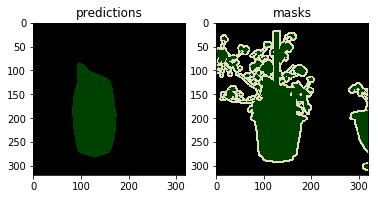

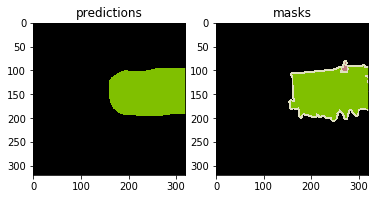

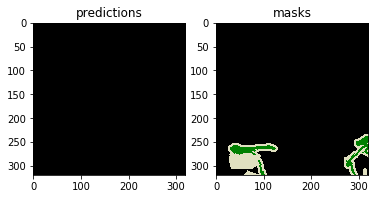

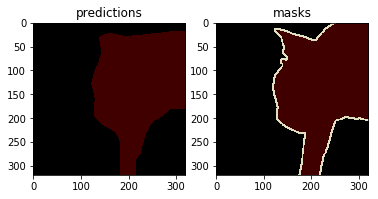

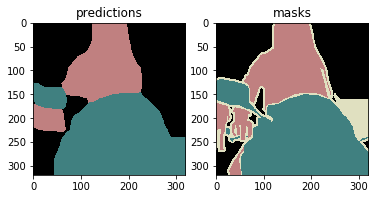

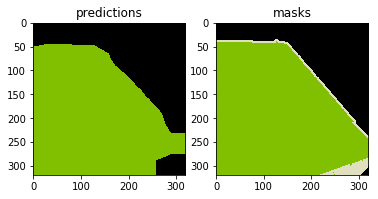

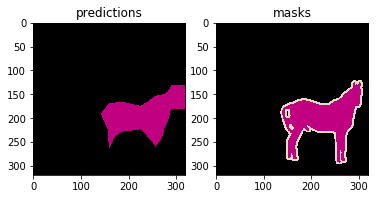

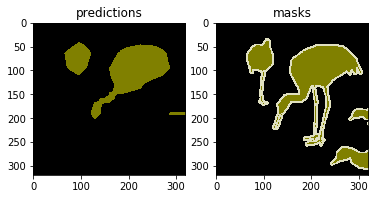

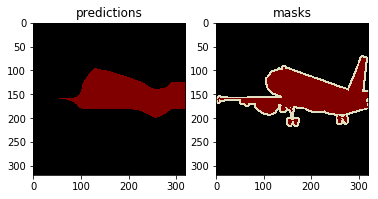

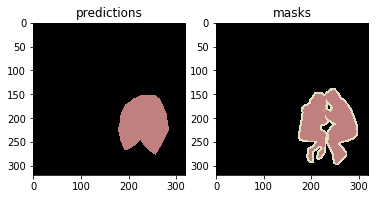

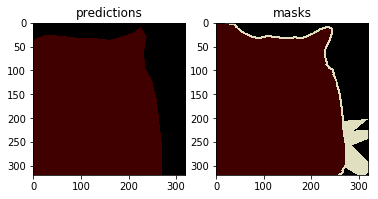

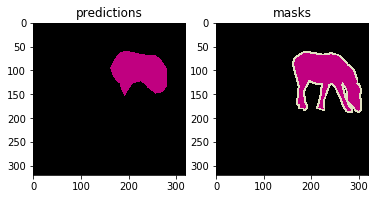

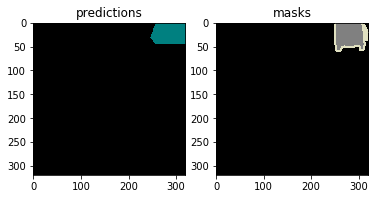

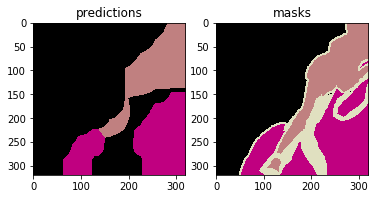

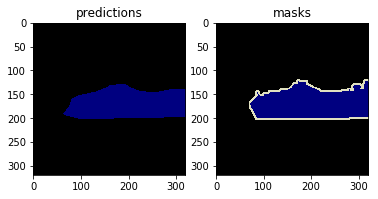

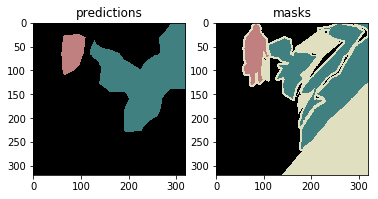

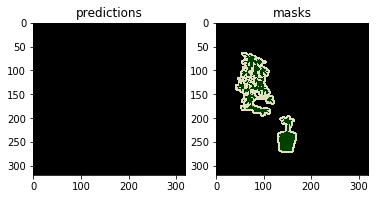

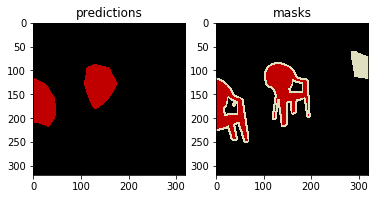

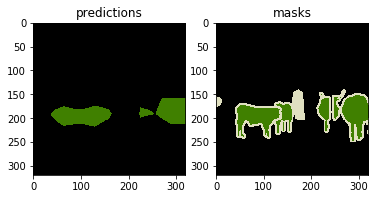

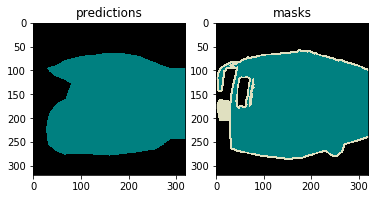

In [7]:
from keras.preprocessing import image



for each in test_data:
    fig=plt.figure()

    each_num=each.split('.')[0]
#     print(each_num)
    img=image.load_img(test_images_path+'/'+each)
    ori_mask=image.load_img(test_masks_path+'/'+each_num+'.png')

    x=image.img_to_array(img)
    x,y=crop_and_pad(x,ori_mask)

    x=np.expand_dims(x,axis=0)
    x=x/255
#     print(x.shape)
    pre=model.predict(x)
#     print(pre)
#     #pre是经过softmax的概率输出，为了可视化，应该将每个像素的最大概率输出的维度置为1，其它为0
    mask = pre.argmax(axis=-1)[...,None] == np.arange(pre.shape[-1])
    out = mask.astype('int')
    
    x=label2image(out[0,:,:,:])
    new_label=labelVisualize(21,colormap,x)
    fig.add_subplot(1,2,1)
    plt.title('predictions')
    plt.imshow(new_label)
    
    fig.add_subplot(1,2,2)
    plt.title('masks')
    plt.imshow(y)

